## Initialization

In [1]:
using Revise, LazySets, NeuralVerification
using NeuralVerification: ReLU, Id
using Plots
using BenchmarkTools

┌ Info: Recompiling stale cache file /home/mforets/.julia/compiled/v1.2/NeuralVerification/sJvOT.ji for NeuralVerification [146f25fa-00e7-11e9-3ae5-fdbac6e12fa7]
└ @ Base loading.jl:1240


## Small nnet

In [2]:
const path = "/home/mforets/.julia/dev/NeuralVerification"

small_nnet_file = path * "/examples/networks/small_nnet_id.nnet"

small_nnet = read_nnet(small_nnet_file, last_layer_activation = ReLU())

Network(NeuralVerification.Layer[NeuralVerification.Layer{ReLU,Float64}([1.0; 1.0], [1.5, 1.5], ReLU()), NeuralVerification.Layer{ReLU,Float64}([2.0 2.0; 2.0 2.0], [2.5, 2.5], ReLU()), NeuralVerification.Layer{ReLU,Float64}([-3.0 -3.0], [3.5], ReLU())])

In [3]:
# The input set is always [-0.9:0.9]
in_hyper  = Hyperrectangle(low = [-0.9], high = [0.9])
in_hpoly  = convert(HPolytope, in_hyper)

# superset of the output
out_superset    = Hyperrectangle(low = [-10.0], high = [10.0])
# includes points in the output region
out_overlapping = Hyperrectangle(low = [-10.0], high = [-5.0])

Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([-7.5], [2.5])

In [4]:
# Group 1
problem_holds = Problem(small_nnet, in_hpoly, convert(HPolytope, out_superset))

Problem{HPolytope{Float64},HPolytope{Float64}}(Network(NeuralVerification.Layer[NeuralVerification.Layer{ReLU,Float64}([1.0; 1.0], [1.5, 1.5], ReLU()), NeuralVerification.Layer{ReLU,Float64}([2.0 2.0; 2.0 2.0], [2.5, 2.5], ReLU()), NeuralVerification.Layer{ReLU,Float64}([-3.0 -3.0], [3.5], ReLU())]), HPolytope{Float64}(HalfSpace{Float64,VN} where VN<:AbstractArray{Float64,1}[HalfSpace{Float64,LazySets.Arrays.SingleEntryVector{Float64}}([1.0], 0.9), HalfSpace{Float64,LazySets.Arrays.SingleEntryVector{Float64}}([-1.0], 0.9)]), HPolytope{Float64}(HalfSpace{Float64,VN} where VN<:AbstractArray{Float64,1}[HalfSpace{Float64,LazySets.Arrays.SingleEntryVector{Float64}}([1.0], 10.0), HalfSpace{Float64,LazySets.Arrays.SingleEntryVector{Float64}}([-1.0], 10.0)]))

In [5]:
problem_violated = Problem(small_nnet, in_hpoly, convert(HPolytope, out_overlapping))

Problem{HPolytope{Float64},HPolytope{Float64}}(Network(NeuralVerification.Layer[NeuralVerification.Layer{ReLU,Float64}([1.0; 1.0], [1.5, 1.5], ReLU()), NeuralVerification.Layer{ReLU,Float64}([2.0 2.0; 2.0 2.0], [2.5, 2.5], ReLU()), NeuralVerification.Layer{ReLU,Float64}([-3.0 -3.0], [3.5], ReLU())]), HPolytope{Float64}(HalfSpace{Float64,VN} where VN<:AbstractArray{Float64,1}[HalfSpace{Float64,LazySets.Arrays.SingleEntryVector{Float64}}([1.0], 0.9), HalfSpace{Float64,LazySets.Arrays.SingleEntryVector{Float64}}([-1.0], 0.9)]), HPolytope{Float64}(HalfSpace{Float64,VN} where VN<:AbstractArray{Float64,1}[HalfSpace{Float64,LazySets.Arrays.SingleEntryVector{Float64}}([1.0], -5.0), HalfSpace{Float64,LazySets.Arrays.SingleEntryVector{Float64}}([-1.0], 10.0)]))

In [6]:
holds = solve(MaxSens(resolution = 0.6), problem_holds)

┌ Info: MaxSens overapproximates HPolytope input sets as Hyperrectangles.
└ @ NeuralVerification /home/mforets/.julia/dev/NeuralVerification/src/reachability/maxSens.jl:91


ReachabilityResult(:holds, Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}[])

In [14]:
holds = solve(ExactReach(), problem_holds)

 = = enter = = 
typeof(M) = Array{Float64,2}
typeof(P) = HPolytope{Float64}
typeof(P.constraints[1]) = HalfSpace{Float64,Array{Float64,1}}
typeof(Ax_leq_b) = Array{Polyhedra.HalfSpace{Float64,Array{Float64,1}},1}
typeof(y_eq_Mx) = Array{Polyhedra.HyperPlane{Float64,Array{Float64,1}},1}
 = = end = =
 = = enter = = 
typeof(M) = Array{Float64,2}
typeof(P) = HPolytope{Float64}
typeof(P.constraints[1]) = HalfSpace{Float64,Array{Float64,1}}
typeof(Ax_leq_b) = Array{Polyhedra.HalfSpace{Float64,Array{Float64,1}},1}
typeof(y_eq_Mx) = Array{Polyhedra.HyperPlane{Float64,Array{Float64,1}},1}
 = = end = =
 = = enter = = 
typeof(M) = Array{Float64,2}
typeof(P) = HPolytope{Float64}
typeof(P.constraints[1]) = HalfSpace{Float64,SparseArrays.SparseVector{Float64,Int64}}
typeof(Ax_leq_b) = Array{Polyhedra.HalfSpace{Float64,Array{Float64,1}},1}
typeof(y_eq_Mx) = Array{Polyhedra.HyperPlane{Float64,Array{Float64,1}},1}
 = = end = =


ReachabilityResult(:holds, HPolytope[])

# Debug. . .

In [11]:
using NeuralVerification: Layer, forward_partition

function solve2(solver::ExactReach, problem::Problem)
    reach = forward_network2(solver, problem.network, problem.input)
    return check_inclusion(reach, problem.output)
end

function forward_network2(solver, nnet::Network, input::AbstractPolytope)
    reach = input
    for layer in nnet.layers
        reach = forward_layer2(solver, layer, reach)
    end
    return reach
end

forward_layer2(solver::ExactReach, layer::Layer, input) = forward_layer2(solver, layer, convert(HPolytope, input))

function forward_layer2(solver::ExactReach, layer::Layer, input::HPolytope)
    input = NeuralVerification.affine_map(layer, input)
    return forward_partition(layer.activation, input)
end

function forward_layer2(solver::ExactReach, layer::Layer, input::Vector{HPolytope})
    output = Vector{HPolytope}(undef, 0)

    for i in 1:length(input)
        input[i] = NeuralVerification.affine_map(layer, input[i])
        append!(output, forward_partition(layer.activation, input[i]))
    end
    return output
end

forward_layer2 (generic function with 3 methods)

In [12]:
# prepare data
solver = ExactReach()

ExactReach()

In [13]:
nnet = problem_holds.network

Network(Layer[Layer{ReLU,Float64}([1.0; 1.0], [1.5, 1.5], ReLU()), Layer{ReLU,Float64}([2.0 2.0; 2.0 2.0], [2.5, 2.5], ReLU()), Layer{ReLU,Float64}([-3.0 -3.0], [3.5], ReLU())])

In [14]:
input = problem_holds.input
input.constraints

2-element Array{HalfSpace{Float64,VN} where VN<:AbstractArray{Float64,1},1}:
 HalfSpace{Float64,LazySets.Arrays.SingleEntryVector{Float64}}([1.0], 0.9) 
 HalfSpace{Float64,LazySets.Arrays.SingleEntryVector{Float64}}([-1.0], 0.9)

In [15]:
output = problem_holds.output
output.constraints

2-element Array{HalfSpace{Float64,VN} where VN<:AbstractArray{Float64,1},1}:
 HalfSpace{Float64,LazySets.Arrays.SingleEntryVector{Float64}}([1.0], 10.0) 
 HalfSpace{Float64,LazySets.Arrays.SingleEntryVector{Float64}}([-1.0], 10.0)

In [17]:
nnet.layers

3-element Array{Layer,1}:
 Layer{ReLU,Float64}([1.0; 1.0], [1.5, 1.5], ReLU())        
 Layer{ReLU,Float64}([2.0 2.0; 2.0 2.0], [2.5, 2.5], ReLU())
 Layer{ReLU,Float64}([-3.0 -3.0], [3.5], ReLU())            

In [18]:
layer = nnet.layers[1]

Layer{ReLU,Float64}([1.0; 1.0], [1.5, 1.5], ReLU())

In [24]:
nnet.layers[3].weights

1×2 Array{Float64,2}:
 -3.0  -3.0

In [187]:
v1 = linear_map(layer.weights, input) # this returns a vpolytope
# we should use followed by a translation, or directly let affine_map work with algorithm...
# translate(linear_map(layer.weights, input, algorithm="lift"), layer.bias)
# affine_map(layer.weights, input, layer.bias, algorithm="lift") # ??

# this is done in NeuralVerification: and then converted back to hrep
# NeuralVerification.translate(layer.bias, NeuralVerification.linear_map(layer.weights, input))
v1 = translate(v1, layer.bias)
h1 = convert(HPolytope, v1)

HPolytope{Float64}(HalfSpace{Float64,VN} where VN<:AbstractArray{Float64,1}[HalfSpace{Float64,Array{Float64,1}}([1.7999999999999998, 1.7999999999999998], 8.639999999999999), HalfSpace{Float64,Array{Float64,1}}([-1.7999999999999998, 1.7999999999999998], 0.0), HalfSpace{Float64,Array{Float64,1}}([-1.7999999999999998, -1.7999999999999998], -2.1599999999999997), HalfSpace{Float64,Array{Float64,1}}([1.7999999999999998, -1.7999999999999998], -0.0)])

In [190]:
# the function forward_partition does the same as 
# LazySets.to_union_of_projections
a = forward_partition(layer.activation, h1)
@show typeof(a)
a[1].constraints

typeof(a) = Array{HPolytope,1}


6-element Array{HalfSpace{Float64,VN} where VN<:AbstractArray{Float64,1},1}:
 HalfSpace{Float64,Array{Float64,1}}([1.7999999999999998, 1.7999999999999998], 8.639999999999999)    
 HalfSpace{Float64,Array{Float64,1}}([-1.7999999999999998, 1.7999999999999998], 0.0)                 
 HalfSpace{Float64,Array{Float64,1}}([-1.7999999999999998, -1.7999999999999998], -2.1599999999999997)
 HalfSpace{Float64,Array{Float64,1}}([1.7999999999999998, -1.7999999999999998], -0.0)                
 HalfSpace{Float64,Array{Float64,1}}([-1.0, 0.0], 0.0)                                               
 HalfSpace{Float64,Array{Float64,1}}([0.0, -1.0], 0.0)                                               

In [184]:
a2 = LazySets.to_union_of_projections(Rectification(h1))
a2.constraints

4-element Array{HalfSpace{Float64,VN} where VN<:AbstractArray{Float64,1},1}:
 HalfSpace{Float64,Array{Float64,1}}([1.7999999999999998, 1.7999999999999998], 8.639999999999999)    
 HalfSpace{Float64,Array{Float64,1}}([-1.7999999999999998, 1.7999999999999998], 0.0)                 
 HalfSpace{Float64,Array{Float64,1}}([-1.7999999999999998, -1.7999999999999998], -2.1599999999999997)
 HalfSpace{Float64,Array{Float64,1}}([1.7999999999999998, -1.7999999999999998], -0.0)                

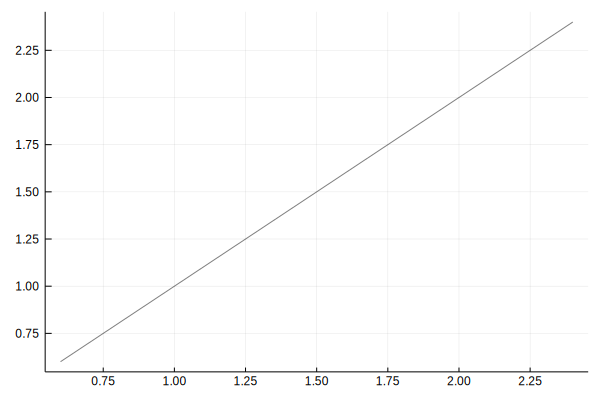

In [126]:
plot(a[1])

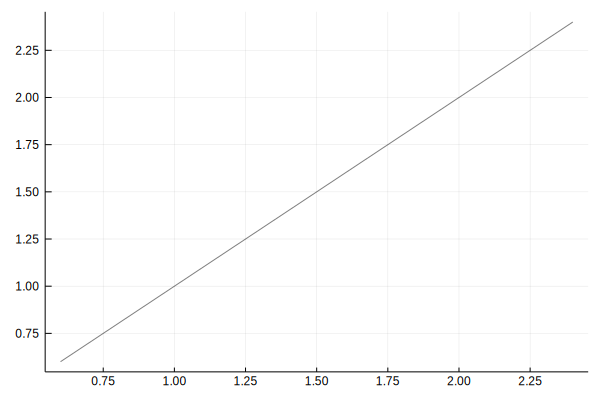

In [127]:
plot(a2)

In [129]:
# the sets are the same
a[1] ⊆ a2 && a2 ⊆ a[1]

true

so the LazySets version removes redundancies.

In [131]:
remove_redundant_constraints(a[1]).constraints

4-element Array{HalfSpace{Float64,VN} where VN<:AbstractArray{Float64,1},1}:
 HalfSpace{Float64,Array{Float64,1}}([1.7999999999999998, 1.7999999999999998], 8.639999999999999)    
 HalfSpace{Float64,Array{Float64,1}}([-1.7999999999999998, 1.7999999999999998], 0.0)                 
 HalfSpace{Float64,Array{Float64,1}}([-1.7999999999999998, -1.7999999999999998], -2.1599999999999997)
 HalfSpace{Float64,Array{Float64,1}}([1.7999999999999998, -1.7999999999999998], -0.0)                

In [133]:
@btime LazySets.to_union_of_projections(Rectification($h1))

  26.828 μs (135 allocations: 8.73 KiB)


HPolytope{Float64}(HalfSpace{Float64,VN} where VN<:AbstractArray{Float64,1}[HalfSpace{Float64,Array{Float64,1}}([1.7999999999999998, 1.7999999999999998], 8.639999999999999), HalfSpace{Float64,Array{Float64,1}}([-1.7999999999999998, 1.7999999999999998], 0.0), HalfSpace{Float64,Array{Float64,1}}([-1.7999999999999998, -1.7999999999999998], -2.1599999999999997), HalfSpace{Float64,Array{Float64,1}}([1.7999999999999998, -1.7999999999999998], -0.0)])

In [134]:
@btime forward_partition($layer.activation, $h1)

  88.295 μs (632 allocations: 40.88 KiB)


1-element Array{HPolytope,1}:
 HPolytope{Float64}(HalfSpace{Float64,VN} where VN<:AbstractArray{Float64,1}[HalfSpace{Float64,Array{Float64,1}}([1.7999999999999998, 1.7999999999999998], 8.639999999999999), HalfSpace{Float64,Array{Float64,1}}([-1.7999999999999998, 1.7999999999999998], 0.0), HalfSpace{Float64,Array{Float64,1}}([-1.7999999999999998, -1.7999999999999998], -2.1599999999999997), HalfSpace{Float64,Array{Float64,1}}([1.7999999999999998, -1.7999999999999998], -0.0), HalfSpace{Float64,Array{Float64,1}}([-1.0, 0.0], 0.0), HalfSpace{Float64,Array{Float64,1}}([0.0, -1.0], 0.0)])

In [186]:
htest = rand(HPolytope, dim=3);
@btime LazySets.to_union_of_projections(Rectification($htest))
@btime forward_partition($layer.activation, $htest);

  101.378 μs (592 allocations: 37.13 KiB)
  6.622 ms (112825 allocations: 7.02 MiB)


In [142]:
x = LazySets.to_union_of_projections(Rectification(htest));

In [157]:
y = forward_partition(layer.activation, htest);
yu = UnionSetArray(convert(Vector{HPolytope{Float64}}, y));

In [174]:
typeof(x) # note that to_union_of_projection takes lazy linear maps, this explains why it is much
# cheaper than forward_partition, which applies a concrete linear map

UnionSetArray{Float64,LinearMap{Float64,S,NM,MAT} where MAT<:AbstractArray{NM,2} where NM where S<:LazySet{Float64}}

In [160]:
x ⊆ yu

MethodError: MethodError: no method matching length(::UnionSetArray{Float64,HPolytope{Float64}})
Closest candidates are:
  length(!Matched::Core.SimpleVector) at essentials.jl:597
  length(!Matched::Base.MethodList) at reflection.jl:819
  length(!Matched::Core.MethodTable) at reflection.jl:893
  ...

In [171]:
a = UnionSetArray([rand(HPolygon) for _ in 1:3])
b = UnionSetArray([rand(HPolygon) for _ in 1:3]);
a ⊆ b

MethodError: MethodError: no method matching length(::UnionSetArray{Float64,HPolygon{Float64}})
Closest candidates are:
  length(!Matched::Core.SimpleVector) at essentials.jl:597
  length(!Matched::Base.MethodList) at reflection.jl:819
  length(!Matched::Core.MethodTable) at reflection.jl:893
  ...

In [172]:
array(a)

3-element Array{HPolygon{Float64},1}:
 HPolygon{Float64}(HalfSpace{Float64,VN} where VN<:AbstractArray{Float64,1}[HalfSpace{Float64,Array{Float64,1}}([2.438846333746284, 0.6022830958190889], 1.0529603950535134), HalfSpace{Float64,Array{Float64,1}}([1.4575593666326343, 0.445113246994651], 0.8136677040382049), HalfSpace{Float64,Array{Float64,1}}([-0.44213426567835734, 1.1798759728035995], 4.516401975383073), HalfSpace{Float64,Array{Float64,1}}([-1.4109598159683434, 0.4302527895751094], 3.806342064463771), HalfSpace{Float64,Array{Float64,1}}([-1.332299385267191, -0.9721680875949463], 1.1551216876131014), HalfSpace{Float64,Array{Float64,1}}([-0.7955871974147848, -1.2035645353093998], 0.41745026384500905), HalfSpace{Float64,Array{Float64,1}}([0.08457496394975839, -0.48179248228810256], 0.17419836196379443)])                                                                                                                                                                                          

In [170]:
@which a ⊆ b

issubset(l, r) in Base at abstractset.jl:233

In [ ]:
forward_partition(layer.activation, z)

In [192]:
holds = solve2(ExactReach(), problem_holds)

AssertionError: AssertionError: a half-space needs a non-zero normal vector

In [202]:
input = problem_holds.input
nnet = problem_holds.network

# layer 1
layer = nnet.layers[1]
tmp = NeuralVerification.affine_map(layer, input)
out1 = forward_partition(layer.activation, tmp)[1]

# layer 2
layer = nnet.layers[2]
tmp = NeuralVerification.affine_map(layer, out1)
out2 = forward_partition(layer.activation, tmp)[1]

# layer 3
layer = nnet.layers[3]
tmp = NeuralVerification.affine_map(layer, out2)
out3 = forward_partition(layer.activation, tmp)[1]

AssertionError: AssertionError: a half-space needs a non-zero normal vector

In [207]:
layer = nnet.layers[3]

Layer{ReLU,Float64}([-3.0 -3.0], [3.5], ReLU())

In [26]:
nnet.layers[1].weights # linear map con "lift"

2×1 Array{Float64,2}:
 1.0
 1.0

In [30]:
nnet.layers[2].weights # linear map con "projection"

2×2 Array{Float64,2}:
 2.0  2.0
 2.0  2.0

## Prueba con zonotope

In [42]:
Zin = convert(Zonotope, in_hyper)

Zonotope{Float64}([0.0], [0.9])

In [48]:
# aplico la primer layer
layer = nnet.layers[1]
Ẑ = affine_map(layer.weights, Zin, layer.bias)

Zonotope{Float64}([1.5, 1.5], [0.9; 0.9])

In [53]:
@btime convert($HPolytope, $Ẑ)

  216.156 μs (3068 allocations: 204.63 KiB)


HPolytope{Float64}(HalfSpace{Float64,VN} where VN<:AbstractArray{Float64,1}[HalfSpace{Float64,Array{Float64,1}}([-0.2562158884172226, 0.25621588841722254], -1.1417779029739671e-17), HalfSpace{Float64,Array{Float64,1}}([0.2562158884172226, -0.25621588841722254], 1.1417779029739671e-17), HalfSpace{Float64,Array{Float64,1}}([0.14705882352941174, 0.14705882352941177], 0.7058823529411765), HalfSpace{Float64,Array{Float64,1}}([-0.17521271831616655, -0.17521271831616658], -0.21025526197939987)])

In [55]:
# aplico ReLu
Z1 = forward_partition(layer.activation, convert(HPolytope, Ẑ))

1-element Array{HPolytope,1}:
 HPolytope{Float64}(HalfSpace{Float64,VN} where VN<:AbstractArray{Float64,1}[HalfSpace{Float64,Array{Float64,1}}([-0.2562158884172226, 0.25621588841722254], -1.1417779029739671e-17), HalfSpace{Float64,Array{Float64,1}}([0.2562158884172226, -0.25621588841722254], 1.1417779029739671e-17), HalfSpace{Float64,Array{Float64,1}}([0.14705882352941174, 0.14705882352941177], 0.7058823529411765), HalfSpace{Float64,Array{Float64,1}}([-0.17521271831616655, -0.17521271831616658], -0.21025526197939987), HalfSpace{Float64,Array{Float64,1}}([-1.0, 0.0], 0.0), HalfSpace{Float64,Array{Float64,1}}([0.0, -1.0], 0.0)])

In [45]:
using Plots

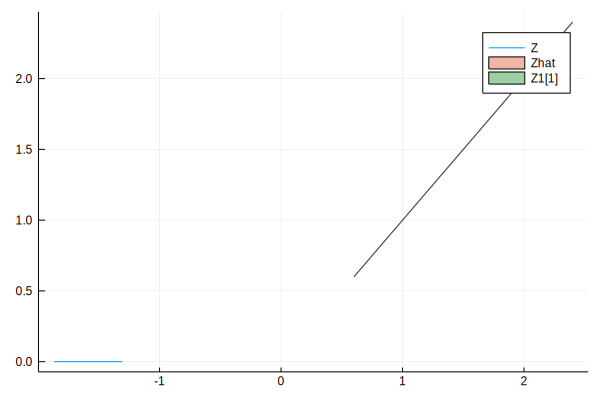

In [56]:
plot(Z, lab="Z")
plot!(Ẑ, lab="Zhat")
plot!(Z1[1], lab="Z1[1]")

In [60]:
Z1[1] ⊆ Ẑ && Ẑ ⊆ Z1[1]
#isequivalent(Z1[1], Ẑ)

true

In [61]:
# aplico la segunda layer a todos los elementos en Z1
layer = nnet.layers[2]
Ẑ1 = [affine_map(layer.weights, Z1[i], layer.bias) for i in eachindex(Z1)]

1-element Array{VPolygon{Float64,Array{Float64,1}},1}:
 VPolygon{Float64,Array{Float64,1}}(Array{Float64,1}[[4.8999999999999995, 4.8999999999999995], [12.100000000000001, 12.100000000000001]])

In [65]:
convert(Zonotope, Z1[1])

MethodError: MethodError: Cannot `convert` an object of type HPolytope{Float64} to an object of type Zonotope
Closest candidates are:
  convert(::Type{Zonotope}, !Matched::Zonotope) at /home/mforets/.julia/dev/LazySets/src/convert.jl:8
  convert(::Type{Zonotope}, !Matched::AbstractHyperrectangle) at /home/mforets/.julia/dev/LazySets/src/convert.jl:259
  convert(::Type{Zonotope}, !Matched::CartesianProduct{N<:Real,Zonotope{N<:Real},Zonotope{N<:Real}}) where N<:Real at /home/mforets/.julia/dev/LazySets/src/convert.jl:687
  ...

In [67]:
Z1[1]

HPolytope{Float64}(HalfSpace{Float64,VN} where VN<:AbstractArray{Float64,1}[HalfSpace{Float64,Array{Float64,1}}([-0.2562158884172226, 0.25621588841722254], -1.1417779029739671e-17), HalfSpace{Float64,Array{Float64,1}}([0.2562158884172226, -0.25621588841722254], 1.1417779029739671e-17), HalfSpace{Float64,Array{Float64,1}}([0.14705882352941174, 0.14705882352941177], 0.7058823529411765), HalfSpace{Float64,Array{Float64,1}}([-0.17521271831616655, -0.17521271831616658], -0.21025526197939987), HalfSpace{Float64,Array{Float64,1}}([-1.0, 0.0], 0.0), HalfSpace{Float64,Array{Float64,1}}([0.0, -1.0], 0.0)])

In [68]:
overapproximate(Z1[1], Zonotope)

MethodError: MethodError: no method matching overapproximate(::HPolytope{Float64}, ::Type{Zonotope})
Closest candidates are:
  overapproximate(::ST<:LazySet{N<:Real}, !Matched::Type{#s74} where #s74<:HPolygon) where {N<:Real, ST<:LazySet{N}} at /home/mforets/.julia/dev/LazySets/src/Approximations/overapproximate.jl:54
  overapproximate(::ST<:LazySet{N<:Real}, !Matched::Type{#s59} where #s59<:HPolygon, !Matched::Real) where {N<:Real, ST<:LazySet{N}} at /home/mforets/.julia/dev/LazySets/src/Approximations/overapproximate.jl:54
  overapproximate(::LazySet{N<:Real}, !Matched::Type{#s95} where #s95<:BallInf) where N<:Real at /home/mforets/.julia/dev/LazySets/src/Approximations/overapproximate.jl:275
  ...

In [69]:
convert(Zonotope, Z1[1])

MethodError: MethodError: Cannot `convert` an object of type HPolytope{Float64} to an object of type Zonotope
Closest candidates are:
  convert(::Type{Zonotope}, !Matched::Zonotope) at /home/mforets/.julia/dev/LazySets/src/convert.jl:8
  convert(::Type{Zonotope}, !Matched::AbstractHyperrectangle) at /home/mforets/.julia/dev/LazySets/src/convert.jl:259
  convert(::Type{Zonotope}, !Matched::CartesianProduct{N<:Real,Zonotope{N<:Real},Zonotope{N<:Real}}) where N<:Real at /home/mforets/.julia/dev/LazySets/src/convert.jl:687
  ...

In [212]:
NeuralVerification.affine_map(layer, out2)

AssertionError: AssertionError: a half-space needs a non-zero normal vector

In [221]:
v1 = linear_map(layer.weights, out2, algorithm="vrep")

Interval{Float64,IntervalArithmetic.Interval{Float64}}([-72.6, -29.3999])

In [222]:
convert(HPolytope, ans)

HPolytope{Float64}(HalfSpace{Float64,VN} where VN<:AbstractArray{Float64,1}[HalfSpace{Float64,LazySets.Arrays.SingleEntryVector{Float64}}([1.0], -29.399999999999995), HalfSpace{Float64,LazySets.Arrays.SingleEntryVector{Float64}}([-1.0], 72.6)])

In [ ]:
# this returns a vpolytope
# we should use followed by a translation, or directly let affine_map work with algorithm...
# translate(linear_map(layer.weights, input, algorithm="lift"), layer.bias)
# affine_map(layer.weights, input, layer.bias, algorithm="lift") # ??

# this is done in NeuralVerification: and then converted back to hrep
# NeuralVerification.translate(layer.bias, NeuralVerification.linear_map(layer.weights, input))
v1 = translate(v1, layer.bias)
h1 = convert(HPolytope, v1)

---

In [ ]:






    @testset "Group 2, 3, 4, 6" begin

        problem_holds    = Problem(small_nnet, in_hyper, HPolytope([HalfSpace([1.], 10.)]))     # y < 10.0
        problem_violated = Problem(small_nnet, in_hyper, HPolytope([HalfSpace([-1.], -20.)]))     # y > 20.0

        group2 = [NSVerify(), MIPVerify(), ILP()]
        group3 = [ConvDual(), Duality()]
        group4 = [FastLin(), FastLip()]
        group6 = [Reluplex(), Planet()]

        for solver in [group2; group3; group4; group6]
            holds    = solve(solver, problem_holds)
            violated = solve(solver, problem_violated)

            @testset "$(typeof(solver))" begin
                @test holds.status    ∈ (:holds, :unknown)
                @test violated.status ∈ (:violated, :unknown)
            end
        end
    end

    @testset "Group 5" begin
        problem_holds    = Problem(small_nnet, in_hyper, out_superset)
        problem_violated = Problem(small_nnet, in_hyper, out_overlapping)

        for solver in [ReluVal(max_iter = 10), DLV(), Sherlock(ϵ = 0.5), BaB()]
            holds    = solve(solver, problem_holds)
            violated = solve(solver, problem_violated)

            @testset "$(typeof(solver))" begin
                @test holds.status    ∈ (:holds, :unknown)
                @test violated.status ∈ (:violated, :unknown)
            end
        end
    end

    @testset "Certify" begin
        ### Certify - only works for single hidden layer
        tiny_nnet = read_nnet("$(@__DIR__)/../examples/networks/tiny_nnet.nnet")
        solver_certify = Certify()
        in_set  = Hyperrectangle([2.0], [.5])
        out_set = HPolytope(ones(1,1), [2.5])
        problem_certify = Problem(tiny_nnet, in_set, out_set)
        @test @no_error solve(solver_certify, problem_certify)
    end
end

In [9]:
for solver in [MaxSens(resolution = 0.6), ExactReach(), Ai2()]
    holds    = solve(solver, problem_holds)
    violated = solve(solver, problem_violated)

    @assert holds.status    ∈ (:holds, :unknown)
    @assert violated.status ∈ (:violated, :unknown)
end

┌ Info: MaxSens overapproximates HPolytope input sets as Hyperrectangles.
└ @ NeuralVerification /home/mforets/.julia/dev/NeuralVerification/src/reachability/maxSens.jl:91
┌ Info: MaxSens overapproximates HPolytope input sets as Hyperrectangles.
└ @ NeuralVerification /home/mforets/.julia/dev/NeuralVerification/src/reachability/maxSens.jl:91


AssertionError: AssertionError: a half-space needs a non-zero normal vector

# MNIST Examples

Ref: file `test/runtime1.jl`.

In [54]:
# ExactReach, ai2, maxSens

using Revise, LazySets, NeuralVerification
using NeuralVerification: ReLU, Id
using Plots
using BenchmarkTools

using NeuralVerification, LazySets, Test, LinearAlgebra
import NeuralVerification: ReLU, Id

# comment to re-enable assertion checks
LazySets.deactivate_assertions()
LazySets.Assertions.deactivate_assertions(NeuralVerification)

macro no_error(ex)
    quote
        try $(esc(ex))
            true
        catch
            false
        end
    end
end

const path = "/home/mforets/.julia/dev/NeuralVerification"

small_nnet_file = path * "/examples/networks/small_nnet_id.nnet"
small_nnet = read_nnet(small_nnet_file, last_layer_activation = ReLU())
small_nnet_file = path * "/examples/networks/small_nnet.nnet"
small_nnet_id_file = path * "/examples/networks/small_nnet_id.nnet"
mnist1_file = path * "/examples/networks/mnist1.nnet"
mnist2_file = path * "/examples/networks/mnist2.nnet"
mnist3_file = path * "/examples/networks/mnist3.nnet"
mnist4_file = path * "/examples/networks/mnist4.nnet"

"/home/mforets/.julia/dev/NeuralVerification/examples/networks/mnist4.nnet"

In [55]:
small_nnet  = read_nnet(small_nnet_file, last_layer_activation = ReLU())
small_nnet_id  = read_nnet(small_nnet_id_file, last_layer_activation = Id())

mnist1 = read_nnet(mnist1_file, last_layer_activation = Id())
mnist2 = read_nnet(mnist2_file, last_layer_activation = Id())
mnist3 = read_nnet(mnist3_file, last_layer_activation = Id())
mnist4 = read_nnet(mnist4_file, last_layer_activation = Id());

# SMALL NNET

In [56]:
println("###### Problem type - input:HPolytope, output:HPolytope ######")
println("###### Network: small_nnet, problem: holds              ######")

in_hyper  = Hyperrectangle(low = [-0.9], high = [0.9])
in_hpoly  = convert(HPolytope, in_hyper)
out_superset    = Hyperrectangle(low = [30.0], high = [80.0])

problem_holds    = Problem(small_nnet, in_hpoly, convert(HPolytope, out_superset))

solver = ExactReach()
println("ExactReach - small_nnet")
timed_result =@timed solve(solver, problem_holds)
println(" - Time: " * string(timed_result[2]) * " s")
println(" - Output: ")
println(timed_result[1])
println("")

solver = Ai2()
println("Ai2 - small_nnet")
timed_result =@timed solve(solver, problem_holds)
println(" - Time: " * string(timed_result[2]) * " s")
println(" - Output: ")
println(timed_result[1])
println("")

solver = MaxSens(resolution = 0.6)
println("MaxSens - small_nnet")
timed_result =@timed solve(solver, problem_holds)
println(" - Time: " * string(timed_result[2]) * " s")
println(" - Output: ")
println(timed_result[1])
println("")

println("###### Problem type - input:HPolytope, output:HPolytope ######")

###### Problem type - input:HPolytope, output:HPolytope ######
###### Network: small_nnet, problem: holds              ######
ExactReach - small_nnet
 - Time: 0.845044358 s
 - Output: 
ReachabilityResult(:holds, HPolytope[])

Ai2 - small_nnet
 - Time: 0.036791328 s
 - Output: 
ReachabilityResult(:holds, HPolytope{Float64}[])

MaxSens - small_nnet
 - Time: 0.334099259 s
 - Output: 
ReachabilityResult(:holds, Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}[])

###### Problem type - input:HPolytope, output:HPolytope ######


┌ Info: MaxSens overapproximates HPolytope input sets as Hyperrectangles.
└ @ NeuralVerification /home/mforets/.julia/dev/NeuralVerification/src/reachability/maxSens.jl:91


# MNIST 1

In [57]:
# entry 23 in MNIST datset
input_center = [0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,121,254,136,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,230,253,248,99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,118,253,253,225,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,61,253,253,253,74,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,206,253,253,186,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,211,253,253,239,69,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,254,253,253,133,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,142,255,253,186,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,149,229,254,207,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,54,229,253,254,105,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,152,254,254,213,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,112,251,253,253,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,212,253,250,149,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36,214,253,253,137,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,75,253,253,253,59,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,93,253,253,189,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,224,253,253,84,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,43,235,253,126,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,99,248,253,119,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,225,235,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
output_center = [-1311.1257826380004,4633.767704436501,-654.0718535670002,-1325.349417307,1175.2361184373997,-1897.8607293569007,-470.3405972940001,830.8337987382,-377.7467076115001,572.3674015264198]

in_epsilon = 1.0 #0-255
out_epsilon = 10.0 #logit domain

input_low = input_center .- in_epsilon
input_high = input_center .+ in_epsilon

output_low = output_center .- out_epsilon
output_high = output_center .+ out_epsilon

inputSet = Hyperrectangle(low=input_low, high=input_high)
outputSet = Hyperrectangle(low=output_low, high=output_high)

problem_mnist = Problem(mnist1, convert(HPolytope, inputSet), convert(HPolytope, outputSet))

## MNIST1 ##
print("\n\n\n")
println("###### Network: mnist1                                  ######")
print("\n\n\n")





###### Network: mnist1                                  ######





### Problem size

In [58]:
h0 = problem_mnist.input;

In [59]:
dim(h0)

784

In [60]:
hout = problem_mnist.output;

In [61]:
dim(hout)

10

In [62]:
lay = problem_mnist.network.layers

2-element Array{NeuralVerification.Layer,1}:
 NeuralVerification.Layer{ReLU,Float64}([-0.0145822 -0.10073 … 0.0317891 -0.121057; 0.0927983 0.0378668 … -0.170367 0.0468094; … ; 0.106251 -0.0527935 … -0.152655 -0.159538; -0.0353035 0.107237 … -0.15136 -0.11534], [0.250202, -0.0460057, 0.197282, 0.206724, 0.19505, 0.123348, 0.195402, 0.195682, 0.270503, 0.0789479  …  0.00734778, 0.195026, 0.139418, 0.188492, 0.36361, -0.0787834, 0.209898, 0.276816, 0.103367, 0.239872], ReLU())
 NeuralVerification.Layer{Id,Float64}([-0.048196 0.0694253 … -0.147897 -0.0522713; -0.165646 0.0419264 … -0.0298784 0.308652; … ; -0.0234716 0.233258 … -0.0833671 0.0769656; 0.253074 0.0652968 … -0.0465979 0.124504], [0.0894416, 0.23172, 0.113948, 0.0927643, 0.180114, 0.294576, 0.107671, 0.216698, -0.0553405, 0.108553], Id())                                                                                                          

In [63]:
size(lay[1].weights)

(25, 784)

In [64]:
size(lay[2].weights)

(10, 25)

In [65]:
# times out
#@time x = linear_map(lay[1].weights, h0, algorithm="elimination");

In [66]:
# prueba haciendo el calculo de forma lazy

In [67]:
h1 = lay[1].weights * h0 ⊕ lay[1].bias;
dim(h1)

25

In [68]:
# test single support-vector evaluation
v = rand(25)
@btime ρ($v, $h1) 
#   62.960 ms (12671 allocations: 9.77 MiB)

  65.734 ms (12671 allocations: 9.77 MiB)


6555.235218337957

In [69]:
# number of constraints in the output
length(hout.constraints)

20

In [70]:
lay[1].activation

ReLU()

In [71]:
# apply the lazy rectification to the lazy set

In [72]:
Rh1 = Rectification(h1);

In [73]:
dim(Rh1)

25

In [74]:
using Optim # required to evaluate the support function of a Rectification, better error message required
# currently it gives UndefVarError: _line_search not defined

In [75]:
Rh1.cache.use_support_vector

false

In [76]:
# ρ(v, Rh1) #times out -- why?

In [ ]:
)

In [77]:
h1 = lay[1].weights * h0 ⊕ lay[1].bias;
dim(h1)

25

In [78]:
z0 = convert(Zonotope, inputSet);

In [130]:
# this works fine
z1 = LazySets.affine_map(lay[1].weights, z0, lay[1].bias)

Zonotope{Float64}([339.974109148, 804.7896889100001, -120.93643818999996, 159.70175620000003, 26.19222235999995, 1580.6718794500002, 690.7373682659999, 1086.72936922, 1152.303486986, 754.8417245400001  …  595.205993736, 398.84354348999994, 1746.50328544, -337.6511418299998, -332.14377932, 621.3071805300001, 157.88175538, 796.44674758, 493.220777666, 1033.8942424680001], [-0.0145822 -0.10073 … 0.0317891 -0.121057; 0.0927983 0.0378668 … -0.170367 0.0468094; … ; 0.106251 -0.0527935 … -0.152655 -0.159538; -0.0353035 0.107237 … -0.15136 -0.11534])

In [135]:
ρ(v, rectify(box_approximation(z1)))

7759.024274278777

In [83]:
constraints_list(z1);

InterruptException: InterruptException:

In [89]:
dim(z0)

784

In [91]:
using OwnTime, Profile

In [158]:
ztest = rand(Zonotope, dim=8)

Profile.clear()
@profile constraints_list(ztest);

In [159]:
yy = constraints_list(ztest);

In [160]:
length(yy)

22880

In [161]:
remove_redundant_constraints!(yy)

InterruptException: InterruptException:

In [162]:
length(yy)

22880

In [113]:
owntime()

 [1]  67% => #lu!#118(::Bool, ::typeof(lu!), ::Array{Float64,2}, ::Val{true}) at lapack.jl:550
 [2]  33% => _array_for at boot.jl:404 [inlined]


In [114]:
totaltime()

 [1] 100% => constraints_list(::Zonotope{Float64}) at AbstractZonotope.jl:436
 [2] 100% => execute_request(::ZMQ.Socket, ::IJulia.Msg) at execute_request.jl:67
 [3] 100% => #constraints_list#330(::Bool, ::typeof(constraints_list), ::Zonotope{Float64}) at AbstractZonotope.jl:464
 [4] 100% => eventloop(::ZMQ.Socket) at eventloop.jl:28
 [5] 100% => eval at boot.jl:330 [inlined]
 [6] 100% => invokelatest at essentials.jl:789 [inlined]
 [7] 100% => eventloop(::ZMQ.Socket) at eventloop.jl:8
 [8] 100% => (::getfield(IJulia, Symbol("##15#18")))() at task.jl:268
 [9] 100% => softscope_include_string(::Module, ::String, ::String) at SoftGlobalScope.jl:218
[10] 100% => #invokelatest#1 at essentials.jl:790 [inlined]
[11]  67% => #lu#122 at lu.jl:142 [inlined]
[12]  67% => #lu at none:0 [inlined]
[13]  67% => det(::SubArray{Float64,2,Array{Float64,2},Tuple{Array{Int64,1},Array{Int64,1}},false}) at generic.jl:1345
[14]  67% => cross_product(::SubArray{Float64,2,Array{Float64,2},Tuple{Base.Slice{Base

In [ ]:
# TIMES OUT
solver = ExactReach()
print("ExactReach - mnist1")
timed_result =@timed solve(solver, problem_mnist)
print(" - Time: " * string(timed_result[2]) * " s")
print(" - Output: ")
print(timed_result[1])

# TIMES OUT
solver = Ai2()
print("Ai2 - mnist1")
timed_result =@timed solve(solver, problem_mnist)
print(" - Time: " * string(timed_result[2]) * " s")
print(" - Output: ")
print(timed_result[1])

solver = MaxSens(resolution = 0.6)
print("MaxSens - mnist1")
#@time solve(solver, problem_hyperrectangle_hyperrectangle_small)
timed_result =@timed solve(solver, problem_mnist)
print(" - Time: " * string(timed_result[2]) * " s")
print(" - Output: ")
print(timed_result[1])

# Other

In [ ]:
## MNIST2 ##
problem_mnist2 = Problem(mnist2, convert(HPolytope, inputSet), convert(HPolytope, outputSet))
print("\n\n\n")
println("###### Network: mnist2                                  ######")
print("\n\n\n")
# TIMES OUT
#solver = ExactReach()
#print("ExactReach - mnist1")
#timed_result =@timed solve(solver, problem_mnist2)
#print(" - Time: " * string(timed_result[2]) * " s")
#print(" - Output: ")
#print(timed_result[1])

# TIMES OUT
#solver = Ai2()
#print("Ai2 - mnist1")
#timed_result =@timed solve(solver, problem_mnist2)
#print(" - Time: " * string(timed_result[2]) * " s")
#print(" - Output: ")
#print(timed_result[1])

solver = MaxSens(resolution = 0.6)
print("MaxSens - mnist2")
timed_result =@timed solve(solver, problem_mnist2)
print(" - Time: " * string(timed_result[2]) * " s")
print(" - Output: ")
print(timed_result[1])


## MNIST3 ##
problem_mnist3 = Problem(mnist3, convert(HPolytope, inputSet), convert(HPolytope, outputSet))
print("\n\n\n")
println("###### Network: mnist3                                  ######")
print("\n\n\n")
# TIMES OUT
#solver = ExactReach()
#print("ExactReach - mnist1")
#timed_result =@timed solve(solver, problem_mnist3)
#print(" - Time: " * string(timed_result[2]) * " s")
#print(" - Output: ")
#print(timed_result[1])

# TIMES OUT
#solver = Ai2()
#print("Ai2 - mnist1")
#timed_result =@timed solve(solver, problem_mnist3)
#print(" - Time: " * string(timed_result[2]) * " s")
#print(" - Output: ")
#print(timed_result[1])

solver = MaxSens(resolution = 0.6)
print("MaxSens - mnist3")
timed_result =@timed solve(solver, problem_mnist3)
print(" - Time: " * string(timed_result[2]) * " s")
print(" - Output: ")
print(timed_result[1])


## MNIST4 ##
problem_mnist4 = Problem(mnist4, convert(HPolytope, inputSet), convert(HPolytope, outputSet))
print("\n\n\n")
println("###### Network: mnist4                                  ######")
print("\n\n\n")

# TIMES OUT

#solver = ExactReach()
#print("ExactReach - mnist1")
#timed_result =@timed solve(solver, problem_mnist4)
#print(" - Time: " * string(timed_result[2]) * " s")
#print(" - Output: ")
#print(timed_result[1])

# TIMES OUT

#solver = Ai2()
#print("Ai2 - mnist1")
#timed_result =@timed solve(solver, problem_mnist4)
#print(" - Time: " * string(timed_result[2]) * " s")
#print(" - Output: ")
#print(timed_result[1])

solver = MaxSens(resolution = 0.6)
print("MaxSens - mnist4")
timed_result =@timed solve(solver, problem_mnist4)
print(" - Time: " * string(timed_result[2]) * " s")
print(" - Output: ")
print(timed_result[1])

# ACAS
print("\n\n\n")
println("###### Problem type - input:HPolytope, output:HPolytope ######")
print("\n\n\n")
println("###### Network: acas                                    ######")
print("\n\n\n")

#acas_file = "$(@__DIR__)/../examples/networks/ACASXU_run2a_1_1_tiny_4.nnet"
acas_file = "$(@__DIR__)/../examples/networks/ACASXU_run2a_4_5_batch_2000.nnet"
#ACASXU_run2a_4_5_batch_2000.nnet

acas_nnet = read_nnet(acas_file, last_layer_activation = Id())

# ACAS PROPERTY 10 - modified
# Original input range:
# LOWER BOUND: array([[ 0.21466922,  0.11140846, -0.4999999 ,  0.3920202 ,  0.15      ]])
# UPPER BOUND: array([[ 0.58819589,  0.4999999 , -0.49840835,  0.66474747,  0.65      ]])
A0 = Matrix{Float64}(I, 5, 5)
A1 = -Matrix{Float64}(I, 5, 5)
A = vcat(A0, A1)


#b_lower = [0.21466922, 0.11140846, -0.4999999, 0.52838384, 0.4]
#b_upper = [0.58819589, 0.4999999 , -0.4999999, 0.52838384, 0.4]

#b_lower = [ 0.21466922,  0.11140846, -0.4999999 ,  0.3920202 ,  0.15      ]
#b_upper = [ 0.58819589,  0.4999999 , -0.49840835,  0.66474747,  0.65      ]

#b_lower = [ 0.21466922,  0.11140846, -0.4999999 ,  0.3920202 ,  0.20      ]
#b_upper = [ 0.58819589,  0.4999999 , -0.49840835,  0.66474747,  0.65      ]

b_lower = [ 0.21466922,  0.11140846, -0.4999999 ,  0.3920202 ,  0.4      ]
b_upper = [ 0.58819589,  0.4999999 , -0.49840835,  0.66474747,  0.4      ]


in_hyper  = Hyperrectangle(low = b_lower, high = b_upper)
inputSet = convert(HPolytope, in_hyper)

#inputSet = HPolytope(A, b)


A = Matrix(undef, 2, 1)
A = [1.0, 0.0, 0.0, 0.0, -1.0]'
b = [0.0]
outputSet = HPolytope(A, b)

problem_polytope_polytope_acas = Problem(acas_nnet, inputSet, outputSet)

# TIMES OUT

#solver = ExactReach()
#print("\nExactReach - ACAS")
#timed_result = @timed solve(solver, problem_polytope_polytope_acas)
#print(" - Time: " * string(timed_result[2]) * " s")
#print(" - Output: ")
#print(timed_result[1])
#println("")

# TIMES OUT

#solver = Ai2()
#print("\nAi2 - ACAS")
#timed_result = @timed solve(solver, problem_polytope_polytope_acas)
#print(" - Time: " * string(timed_result[2]) * " s")
#print(" - Output: ")
#print(timed_result[1])
#println("")

solver = MaxSens(1.0, false)
println("MaxSens - ACAS")
timed_result = @timed solve(solver, problem_polytope_polytope_acas)
println(" - Time: " * string(timed_result[2]) * " s")
println(" - Output: ")
println(timed_result[1])
println("")
